In [1]:
from pyspark.sql import SparkSession,SQLContext
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
import time
from operator import add
from pyspark import SparkConf, SparkContext
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
import dataframe_image as dfi
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
import numpy as np
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, StopWordsRemover

def preprocess(rdd):
    rdd= rdd.split(" ")
    rddnew=[]
    for x in rdd:
        if "." in x:
            x=x.replace(".","")
        if ":" in x:
            x=x.replace(":","")
        if "," in x:
            x=x.replace(",","")
        if " " in x:
            x=x.replace(" ","")
        if '"' in x:
            x=x.replace('"',"")
        if "\n" in x:
            x=x.replace("\n"," ")
        rddnew.append(x.lower())
    return rddnew

In [2]:
Sample_ratio=0.001 #Change this sample ratio to obtain running time of about 2mins

def get_most_popular(df):
    df=df.sample(Sample_ratio) 
    #Get df with 20 most popular (defined by number of comments) subreddits.
    subreddits = df.select("Subreddit").rdd.flatMap(lambda x:x).map(lambda x: (x,1)).reduceByKey(add).toDF(["Subreddit","comment_count"]).sort("comment_count",ascending=False).limit(20)

    #Get df with average comment lenght for those 20 most popular
    top_subreddits = subreddits.select("Subreddit").rdd.flatMap(lambda x:x).collect()
    top_subreddits_average_lenght=[]
    for x in top_subreddits:

        top_subreddits_average_lenght.append(int(df.where(df["Subreddit"]==x).select("body").rdd.flatMap(lambda x:x).map(lambda x: x.split(" ")).map(lambda x: len(x)).mean()))

    z=zip(top_subreddits_average_lenght,top_subreddits)
    
    df1=spark.createDataFrame(z,["average_lenght","Subreddit"])
    #Join the two dataframes
    df2=df1.join(subreddits,"Subreddit")
    pandas_df=df2.toPandas()

    df_styled = pandas_df.style.background_gradient().hide(axis="index")
    #dfi.export(df_styled,"popular.png",fontsize=3.8, dpi=800,  table_conversion='chrome', chrome_path=None)
    return df_styled

def get_groups(df):
    df=df.sample(Sample_ratio)
    #concatenate comments by subreddit
    subreddits = df.select("Subreddit").rdd.flatMap(lambda x:x).map(lambda x: (x,1)).reduceByKey(add).toDF(["Subreddit","comment_count"]).sort("comment_count",ascending=False).limit(20)

    #Get df with average comment lenght for those 20 most popular
    top_subreddits = subreddits.select("Subreddit").rdd.flatMap(lambda x:x).collect()
    df4=df.filter(df.subreddit.isin(top_subreddits)).select("Subreddit", "body").rdd.map(lambda x:x).map(lambda x: (x[0],x[1])).reduceByKey(add)
    df5=df4.toDF()

    #run pipeline
    
    tokenizer = Tokenizer(inputCol="_2", outputCol="tokens")
    remover = StopWordsRemover(inputCol="tokens", outputCol="stopWordsRemovedTokens")
    hashingTF = HashingTF(inputCol="stopWordsRemovedTokens", outputCol="rawFeatures", numFeatures=2000)
    idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)
    from pyspark.ml.clustering import KMeans
    kmeans = KMeans(k=2)

    from pyspark.ml import Pipeline
    pipeline = Pipeline(stages=[tokenizer,remover,hashingTF,idf,kmeans])
    model = pipeline.fit(df5)
    results = model.transform(df5)

    #Merge cluster with previous table
    df3=results.selectExpr("_1 as Subreddit", "prediction as group").sort("group").toPandas()
    df_styled = df3.style.background_gradient().hide(axis="index")
    #dfi.export(df_styled,"groups.png",fontsize=3.8, dpi=800,  table_conversion='chrome', chrome_path=None)
    return df_styled

#time in the day of comments
def get_comments_time(df):
    
    fig, ax = plt.subplots()

    hist(ax, df.select('hour'), bins = 24, color=['grey'])
    plt.savefig('comments_time.png')
    plt.clf()

def get_words_use(df):
    first_word="night"
    second_word="midnight"
    third_word="morning"
    word1=[]
    word2=[]
    word3=[]
    x=list(range(24))
    for _ in x:

        df1=df.filter(df.hour==_).select("body").rdd.flatMap(lambda x:x).flatMap(lambda x: preprocess(x)).map(lambda x: (x,1)).reduceByKey(add).toDF(["word","count"])
        try:
            word1.append(df1.filter(df1.word==f"{first_word}").collect()[0][1]/df1.groupBy().sum().collect()[0][0])
        except IndexError:
            word1.append(0)
        try:
            word2.append(df1.filter(df1.word==f"{second_word}").collect()[0][1]/df1.groupBy().sum().collect()[0][0])
        except IndexError:
            word2.append(0)
        try:
            word3.append(df1.filter(df1.word==f"{third_word}").collect()[0][1]/df1.groupBy().sum().collect()[0][0])
        except IndexError:
            word3.append(0)

    fig = plt.figure(facecolor=(1, 1, 1))
    plt.plot(x, word1,label=f"word={first_word}")
    plt.plot(x, word2,label=f"word={second_word}")
    plt.plot(x, word3,label=f"word={third_word}")
    plt.legend()
    plt.xlabel("hour time")
    plt.ylabel("word frequency")
    plt.savefig('words_frequency.png')
    plt.clf()

23/03/18 14:40:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/18 15:10:54 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/18 15:10:54 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


cores=10, elapsed_time=1395.335 seconds


cores=24, elapsed_time=1319.310 seconds


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

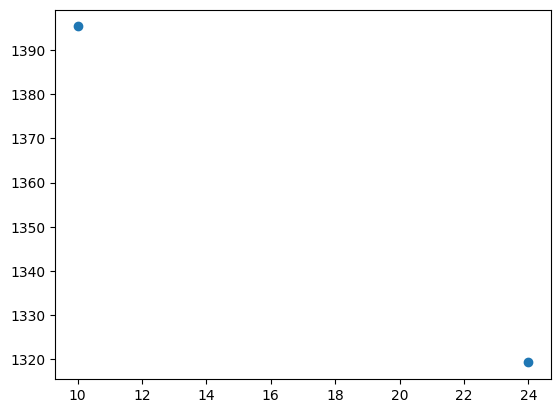

In [3]:
timing=[]
core=(10,24) #Change to 33?
for x in core:

    spark = SparkSession.builder\
        .master("spark://192.168.2.102:7077") \
        .appName("experiments")\
        .config("spark.cores.max", f"{x}")\
        .getOrCreate()

    sqlContext = SQLContext(spark.sparkContext)

    df = spark.read.json("hdfs://130.238.29.139:9000/reddit/RC_2011-08.json") #Change to latest data
    df.createOrReplaceTempView('park') #preparing dataframe sql
    df = sqlContext.sql("select body,created_utc,subreddit from park").where(df["body"]!="[deleted]").withColumn("hour",hour(from_unixtime(col("created_utc"))))

    start = time.time()
        
    get_comments_time(df)
    get_words_use(df)
    get_most_popular(df)
    get_groups(df)

    end = time.time()
    timing.append(end-start)
    #print(f"cores={x}, result={result}, elapsed_time={end-start:.3f} seconds")
    print(f"cores={x}, elapsed_time={end-start:.3f} seconds")
    #spark.stop()

plt.scatter(core,timing)
plt.savefig("Timing Cores 1-32")

In [4]:
get_groups(df)


Subreddit,group
AskReddit,0
atheism,1
Minecraft,1
starcraft,1
WTF,1
gaming,1
trees,1
TwoXChromosomes,1
leagueoflegends,1
mylittlepony,1


In [5]:
get_most_popular(df)

Subreddit,average_lenght,comment_count
AskReddit,30,1710
pics,20,915
gaming,28,512
reddit.com,24,465
IAmA,39,368
funny,19,364
fffffffuuuuuuuuuuuu,18,355
politics,49,290
atheism,45,267
trees,21,257
